In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,InputLayer,LayerNormalization,Dropout,Input,MultiHeadAttention,Embedding,TextVectorization)
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from google.colab import drive
from google.colab import files

In [ ]:
tf.__version__

'2.15.0'

# Data Preparation

## Data Download

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2024-01-27 15:12:23--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7833145 (7.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.47M  20.7MB/s    in 0.4s    

2024-01-27 15:12:23 (20.7 MB/s) - ‘fra-eng.zip’ saved [7833145/7833145]



In [ ]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Data Processing

In [ ]:
# Load the text data from a file into a tf.data.TextLineDataset object
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [ ]:
# Define constants for vocabulary size, sequence lengths, embedding dimensions, and batch size
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=32
FRENCH_SEQUENCE_LENGTH=32
EMBEDDING_DIM=256
BATCH_SIZE=128

In [ ]:
# Create a TextVectorization layer for English and French with specified parameters
english_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',  # Convert text to lowercase and strip punctuation
    max_tokens=VOCAB_SIZE,                      # Set the maximum number of tokens in the vocabulary
    output_mode='int',                         # Output integer indices for tokens
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH  # Pad or truncate sequences to this length
)


french_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',  # Convert text to lowercase and strip punctuation
    max_tokens=VOCAB_SIZE,                      # Set the maximum number of tokens in the vocabulary
    output_mode='int',                         # Output integer indices for tokens
    output_sequence_length=FRENCH_SEQUENCE_LENGTH  # Pad or truncate sequences to this length
)

In [ ]:
# Function to split the text into input and output sequences
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [ ]:
# Function to separate text into input and output sequences for training
def separator(input_text):
    split_text = tf.strings.split(input_text, '\t')  # Split text by tab
    # Return input and output sequences
    return split_text[0:1], 'starttoken ' + split_text[1:2] + ' endtoken'

In [ ]:
# Apply the selector function to the text dataset
split_dataset = text_dataset.map(selector)

# Create an initial dataset for English and French sequences
init_dataset = text_dataset.map(separator)


In [ ]:
# samples
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
# Function to apply vectorization to the dataset
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
# Apply the vectorizer function to the split dataset
dataset=split_dataset.map(vectorizer)

In [ ]:
# sample
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [ ]:
# sample
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[  2, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>)


In [ ]:
# Shuffle, unbatch, batch, and prefetch the dataset for training
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
NUM_BATCHES = int(200000/BATCH_SIZE)

In [ ]:
# Split the dataset into training and validation sets
train_dataset = dataset.take(int(0.9 * NUM_BATCHES))  # 90% for training
val_dataset = dataset.skip(int(0.9 * NUM_BATCHES))  # 10% for validation

# Modeling

## Embedding

In [ ]:
# Purpose: Computes positional encodings for sequences to provide information about token positions, necessary for models like Transformers that do not have inherent position-awareness.

def positional_encoding(model_size, SEQUENCE_LENGTH):
  """
  Computes positional encoding for a sequence of given length and model size.

  Args:
      model_size (int): Dimensionality of the positional encoding vectors (embedding size).
      SEQUENCE_LENGTH (int): Length of the sequence for which positional encodings are computed.

  Returns:
      tf.Tensor: A tensor of shape (1, SEQUENCE_LENGTH, model_size) containing the positional encodings.
  """
  
  output = []  # List to store positional encoding vectors for each position

  for pos in range(SEQUENCE_LENGTH):
      PE = np.zeros((model_size))  # Initialize a vector for the current position with zeros
      
      for i in range(model_size):
          if i % 2 == 0:
              # For even indices, use the sine function
              PE[i] = np.sin(pos / (10000 ** (i / model_size)))
          else:
              # For odd indices, use the cosine function
              PE[i] = np.cos(pos / (10000 ** ((i - 1) / model_size)))
      
      output.append(tf.expand_dims(PE, axis=0))  # Add the positional encoding vector to the list, expanding dims for batch dimension

  out = tf.concat(output, axis=0)  # Concatenate all positional encoding vectors along the first axis (sequence length)
  out = tf.expand_dims(out, axis=0)  # Add an additional dimension for the batch size (batch dimension)

  return tf.cast(out, dtype=tf.float32)  # Cast the output tensor to float32 and return it


In [ ]:
print(positional_encoding(256,64).shape)

(1, 64, 256)


In [ ]:
# The Embeddings class combines token embeddings with positional encodings, providing enriched token representations with positional information for sequence data.

class Embeddings(Layer):
    """
    Custom embedding layer that combines token embeddings with positional encodings.

    Args:
        sequence_length (int): Length of the input sequences.
        vocab_size (int): Size of the vocabulary (number of unique tokens).
        embed_dim (int): Dimensionality of the embedding vectors.
    
    Attributes:
        token_embeddings (tf.keras.layers.Embedding): Layer for token embeddings.
        sequence_length (int): Length of the input sequences.
        vocab_size (int): Size of the vocabulary.
        embed_dim (int): Dimensionality of the embedding vectors.
    """
    
    def __init__(self, sequence_length, vocab_size, embed_dim):
        """
        Initialize the Embeddings layer.

        Args:
            sequence_length (int): Length of the input sequences.
            vocab_size (int): Size of the vocabulary.
            embed_dim (int): Dimensionality of the embedding vectors.
        """
        super(Embeddings, self).__init__()
        # Initialize the token embeddings layer
        self.token_embeddings = Embedding(
            input_dim=vocab_size, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        """
        Forward pass of the layer.

        Args:
            inputs (tf.Tensor): Input tensor containing token indices.

        Returns:
            tf.Tensor: Sum of token embeddings and positional encodings.
        """
        # Compute token embeddings for the input tokens
        embedded_tokens = self.token_embeddings(inputs)
        # Compute positional encodings based on embedding dimension and sequence length
        embedded_positions = positional_encoding(
            self.embed_dim, self.sequence_length)
        # Add token embeddings and positional encodings to get the final embeddings
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        """
        Compute a mask for the input tensor, indicating valid positions.

        Args:
            inputs (tf.Tensor): Input tensor to compute the mask for.
            mask (tf.Tensor, optional): Optional mask tensor (not used here).

        Returns:
            tf.Tensor: Boolean tensor where non-zero positions are marked as True.
        """
        # Return a boolean mask indicating non-zero positions in the input tensor
        return tf.math.not_equal(inputs, 0)


In [ ]:
# testing
test_input=tf.constant([[2,4,7,21,3,5,0,0]])
emb=Embeddings(8,20000,512)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 512)


In [ ]:
# testing
mask = emb.compute_mask(test_input)
print(mask)


padding_mask = tf.cast(
    tf.repeat(mask,repeats=tf.shape(mask)[1],axis=0),
    dtype=tf.int32)
print(padding_mask)

tf.Tensor([[ True  True  True  True  True  True False False]], shape=(1, 8), dtype=bool)
tf.Tensor(
[[1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 0 0]], shape=(8, 8), dtype=int32)


## Custom MultiHeadAttention

In [ ]:
class CustomSelfAttention(Layer):
  def __init__(self, model_size):
      """
      Initialize the CustomSelfAttention layer.
      
      Args:
          model_size (int): The size of the model (dimension of the query/key/value vectors).
      """
      super(CustomSelfAttention, self).__init__()
      self.model_size = model_size

  def call(self, query, key, value, masking):
      """
      Perform the self-attention operation.
      
      Args:
          query (Tensor): Query matrix of shape (batch_size, seq_length, model_size).
          key (Tensor): Key matrix of shape (batch_size, seq_length, model_size).
          value (Tensor): Value matrix of shape (batch_size, seq_length, model_size).
          masking (Tensor): Masking tensor of shape (batch_size, seq_length, seq_length), 
                            where masked positions are set to 0 and unmasked to 1.
      
      Returns:
          Tensor: The output of the self-attention layer of shape (batch_size, seq_length, model_size).
      """
      ######## Compute scores by performing matrix multiplication between query and key (transpose_b=True).
      score = tf.matmul(query, key, transpose_b=True)
      
      ######## Scale the scores by dividing by the square root of the model size.
      score /= tf.math.sqrt(tf.cast(self.model_size, tf.float32))
      
      ######## Apply masking by adding a large negative value (-1e10) to masked positions to ensure they are not attended to.
      masking = tf.cast(masking, dtype=tf.float32)
      score += (1. - masking) * -1e10
      
      ######## Compute attention weights using the softmax function, and apply masking.
      attention = tf.nn.softmax(score, axis=-1) * masking
      
      ######## Compute the output by performing matrix multiplication between attention weights and value.
      head = tf.matmul(attention, value)
      
      return head


In [ ]:
# testing
attention=CustomSelfAttention(256)
attention(tf.ones([1,8,256]),tf.ones([1,8,256]),tf.ones([1,8,256]),padding_mask)

<tf.Tensor: shape=(1, 8, 256), dtype=float32, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

In [ ]:
class CustomMultiHeadAttention(Layer):
  def __init__(self, num_heads, key_dim):
      """
      Initialize the CustomMultiHeadAttention layer.
      
      Args:
          num_heads (int): Number of attention heads.
          key_dim (int): Dimension of the key, query, and value vectors.
      """
      super(CustomMultiHeadAttention, self).__init__()

      # Number of attention heads
      self.num_heads = num_heads
      
      # Define dense layers for query, key, and value for each head
      self.dense_q = [Dense(key_dim // num_heads) for _ in range(num_heads)]
      self.dense_k = [Dense(key_dim // num_heads) for _ in range(num_heads)]
      self.dense_v = [Dense(key_dim // num_heads) for _ in range(num_heads)]
      
      # Dense layer to project the concatenated heads back to the original key dimension
      self.dense_o = Dense(key_dim)
  
      # Instance of the custom self-attention mechanism
      self.self_attention = CustomSelfAttention(key_dim)


  def call(self, query, key, value, attention_mask):
      """
      Perform the multi-head attention operation.
      
      Args:
          query (Tensor): Query matrix of shape (batch_size, seq_length, key_dim).
          key (Tensor): Key matrix of shape (batch_size, seq_length, key_dim).
          value (Tensor): Value matrix of shape (batch_size, seq_length, key_dim).
          attention_mask (Tensor): Masking tensor of shape (batch_size, seq_length, seq_length),
                                    where masked positions are set to 0 and unmasked to 1.
      
      Returns:
          Tensor: The output of the multi-head attention layer of shape (batch_size, seq_length, key_dim).
      """
      heads = []

      # Loop through each head to compute self-attention for each
      for i in range(self.num_heads):
          # Apply dense layers to the query, key, and value for the current head
          head = self.self_attention(self.dense_q[i](query), self.dense_k[i](key),
                                      self.dense_v[i](value), attention_mask)
          heads.append(head)
      
      # Concatenate the results from all heads along the last dimension
      heads = tf.concat(heads, axis=2)
      
      # Apply the output dense layer to project back to the original key dimension
      heads = self.dense_o(heads)
      
      return heads


## Encoder

In [ ]:
#?tf.keras.layers.MultiHeadAttention

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        """
        Initialize the TransformerEncoder layer.
        
        Args:
            embed_dim (int): Dimension of the embedding vectors.
            dense_dim (int): Dimension of the dense projection layer.
            num_heads (int): Number of attention heads.
        """
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        # Multi-head attention layer
        self.attention = CustomMultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        # Sequential dense projection layer with ReLU activation followed by a linear layer
        self.dense_proj = tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim)]
        )
        
        # Layer normalization for the residual connections
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        
        # Support masking in the encoder layer
        self.supports_masking = True

    def call(self, inputs, mask=None):
        """
        Perform the forward pass of the Transformer encoder layer.
        
        Args:
            inputs (Tensor): Input tensor of shape (batch_size, seq_length, embed_dim).
            mask (Tensor, optional): Optional masking tensor of shape (batch_size, seq_length) 
                                     to avoid attending to certain positions.
        
        Returns:
            Tensor: The output tensor of the Transformer encoder layer of shape 
                    (batch_size, seq_length, embed_dim).
        """

        # Prepare the padding mask for the attention mechanism, if provided
        if mask is not None:
            mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            T = tf.shape(mask)[2]
            padding_mask = tf.repeat(mask, T, axis=1)
        else:
            padding_mask = None

        # Apply the multi-head attention layer with the padding mask
        attention_output = self.attention(
            query=inputs, key=inputs, value=inputs,
            attention_mask=padding_mask
        )

        # Add and normalize the residual connection (input + attention output)
        proj_input = self.layernorm_1(inputs + attention_output)
        
        # Apply the dense projection layer
        proj_output = self.dense_proj(proj_input)
        
        # Add and normalize the residual connection (proj_input + proj_output)
        return self.layernorm_2(proj_input + proj_output)


In [ ]:
# testing
encoder_outputs = TransformerEncoder(512,2048,8)(emb_out)
print(encoder_outputs.shape)


hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
hello (1, 8, 64)
head (8, 1, 8, 64)
(1, 8, 512)


## Decoder

In [ ]:
class TransformerDecoder(Layer):
  def __init__(self, embed_dim, latent_dim, num_heads):
      """
      Initialize the TransformerDecoder layer.
      
      Args:
          embed_dim (int): Dimension of the embedding vectors.
          latent_dim (int): Dimension of the dense projection layer.
          num_heads (int): Number of attention heads.
      """
      super(TransformerDecoder, self).__init__()
      self.embed_dim = embed_dim
      self.latent_dim = latent_dim
      self.num_heads = num_heads
      
      # First multi-head self-attention layer (attends to the decoder's own inputs)
      self.attention_1 = MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim
      )
      
      # Second multi-head attention layer (attends to the encoder's output)
      self.attention_2 = MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim
      )
      
      # Dense projection layer with ReLU activation followed by a linear layer
      self.dense_proj = tf.keras.Sequential(
          [Dense(latent_dim, activation="relu"), Dense(embed_dim)]
      )
      
      # Layer normalization layers for the residual connections
      self.layernorm_1 = LayerNormalization()
      self.layernorm_2 = LayerNormalization()
      self.layernorm_3 = LayerNormalization()
      
      # Support masking in the decoder layer
      self.supports_masking = True

  def call(self, inputs, encoder_outputs, enc_mask, mask=None):
      """
      Perform the forward pass of the Transformer decoder layer.
      
      Args:
          inputs (Tensor): Input tensor (decoder input) of shape (batch_size, seq_length, embed_dim).
          encoder_outputs (Tensor): Encoder output tensor of shape (batch_size, seq_length, embed_dim).
          enc_mask (Tensor): Masking tensor for the encoder outputs of shape (batch_size, seq_length).
          mask (Tensor, optional): Optional masking tensor for the decoder input of shape 
                                    (batch_size, seq_length) to avoid attending to certain positions.
      
      Returns:
          Tensor: The output tensor of the Transformer decoder layer of shape 
                  (batch_size, seq_length, embed_dim).
      """

      # Prepare the causal mask (prevents attending to future positions in the sequence)
      if mask is not None:
          causal_mask = tf.linalg.band_part(
              tf.ones([tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[1]], dtype=tf.int32), -1, 0
          )
          
          # Convert mask and encoder mask to the correct shape and type
          mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
          enc_mask = tf.cast(enc_mask[:, tf.newaxis, :], dtype="int32")
          
          # Create padding masks for the attention mechanisms
          T = tf.shape(mask)[2]
          padding_mask = tf.repeat(mask, T, axis=1)
          cross_attn_mask = tf.repeat(enc_mask, T, axis=1)
          
          # Combine causal and padding masks
          combined_mask = tf.minimum(padding_mask, causal_mask)
      else:
          combined_mask = None
          cross_attn_mask = None

      # First attention block: self-attention over the decoder's inputs
      attention_output_1 = self.attention_1(
          query=inputs, key=inputs, value=inputs,
          attention_mask=combined_mask,
      )
      
      # Add and normalize the residual connection (input + attention output)
      out_1 = self.layernorm_1(inputs + attention_output_1)
      
      # Second attention block: attention over the encoder's outputs
      attention_output_2 = self.attention_2(
          query=out_1, key=encoder_outputs, value=encoder_outputs,
          attention_mask=cross_attn_mask,
      )
      
      # Add and normalize the residual connection (out_1 + attention output)
      out_2 = self.layernorm_2(out_1 + attention_output_2)
      
      # Apply the dense projection layer
      proj_output = self.dense_proj(out_2)
      
      # Add and normalize the residual connection (out_2 + proj_output)
      return self.layernorm_3(out_2 + proj_output)


In [ ]:
enc_mask=mask
decoder_outputs = TransformerDecoder(512,2048,4)(emb_out,encoder_outputs,enc_mask)
print(decoder_outputs.shape)

before tf.Tensor([[ True  True  True  True  True  True False False]], shape=(1, 8), dtype=bool) (1, 8)
the boy tf.Tensor([[[1 1 1 1 1 1 0 0]]], shape=(1, 1, 8), dtype=int32) (1, 1, 8)
(1, 8, 512)


## Transformer Model

In [ ]:
EMBEDDING_DIM=512
D_FF=2048
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=10

In [ ]:
# Define the input layer for the encoder (English input sequence)
encoder_inputs = Input(shape=(None,), dtype="int64", name="input_1")
# Create the embedding layer for the encoder input
emb = Embeddings(ENGLISH_SEQUENCE_LENGTH, VOCAB_SIZE, EMBEDDING_DIM)
# Embed the encoder inputs
x = emb(encoder_inputs)
# Compute the mask for the encoder inputs
enc_mask = emb.compute_mask(encoder_inputs)

# Apply the Transformer encoder layers sequentially
for _ in range(NUM_LAYERS):
    x = TransformerEncoder(EMBEDDING_DIM, D_FF, NUM_HEADS)(x)

# Final encoder output after applying all encoder layers
encoder_outputs = x



# -------------------- decoder part ---------------

# Define the input layer for the decoder (French input sequence)
decoder_inputs = Input(shape=(None,), dtype="int64", name="input_2")
# Embed the decoder inputs
x = Embeddings(FRENCH_SEQUENCE_LENGTH, VOCAB_SIZE, EMBEDDING_DIM)(decoder_inputs)

# Apply the Transformer decoder layers sequentially
for i in range(NUM_LAYERS):
    x = TransformerDecoder(EMBEDDING_DIM, D_FF, NUM_HEADS)(x, encoder_outputs, enc_mask)

# Apply a dropout layer for regularization
x = tf.keras.layers.Dropout(0.5)(x)
# Apply the final dense layer with softmax activation to predict the output sequence
decoder_outputs = Dense(VOCAB_SIZE, activation="softmax")(x)
# Define the complete Transformer model with encoder and decoder inputs and outputs
transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)


# Print a summary of the Transformer model
transformer.summary()


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embeddings_3 (Embeddings)      (None, 32, 512)      10240000    ['input_1[0][0]']                
                                                                                                  
 embeddings_4 (Embeddings)      (None, 32, 512)      10240000    ['input_2[0][0]']                
                                                                                        

# Training

In [ ]:
class Scheduler(LearningRateSchedule):
    def __init__(self, d_model, warmup_steps):
        """
        Initialize the learning rate scheduler.
        
        Args:
            d_model (int): Dimension of the model (usually the embedding dimension).
            warmup_steps (int): Number of steps during which the learning rate is increased.
        """
        super(Scheduler, self).__init__()
        
        # Cast the model dimension and warmup steps to float64 for precision
        self.d_model = tf.cast(d_model, tf.float64)
        self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float64)

    def __call__(self, step):
        """
        Compute the learning rate for a given training step.
        
        Args:
            step (int or Tensor): The current training step.
        
        Returns:
            Tensor: The computed learning rate for the given step.
        """
        # Cast the current step to float64 for precision
        step = tf.cast(step, dtype=tf.float64)
        
        # Calculate the learning rate using the formula from the "Attention Is All You Need" paper
        learning_rate = (self.d_model**(-0.5)) * tf.math.minimum(
            step**(-0.5), step * (self.warmup_steps ** -1.5)
        )
        
        return learning_rate


In [ ]:
WARM_UP_STEPS = 4000
lr_scheduled = Scheduler(EMBEDDING_DIM, WARM_UP_STEPS)

In [ ]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = Adam(lr_scheduled)
    )

In [ ]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
1405/1405 [==============================] - 365s 237ms/step - loss: 5.4511 - val_loss: 4.7071
Epoch 2/10
1405/1405 [==============================] - 213s 151ms/step - loss: 3.3392 - val_loss: 3.7340
Epoch 3/10
1405/1405 [==============================] - 211s 149ms/step - loss: 2.6036 - val_loss: 3.3412
Epoch 4/10
1405/1405 [==============================] - 208s 148ms/step - loss: 2.1854 - val_loss: 3.0057
Epoch 5/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.9171 - val_loss: 2.8613
Epoch 6/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.7524 - val_loss: 2.7807
Epoch 7/10
1405/1405 [==============================] - 209s 148ms/step - loss: 1.6374 - val_loss: 2.7714
Epoch 8/10
1405/1405 [==============================] - 207s 147ms/step - loss: 1.5560 - val_loss: 2.7180
Epoch 9/10
1405/1405 [==============================] - 208s 148ms/step - loss: 1.4913 - val_loss: 2.7244
Epoch 10/10
1405/1405 [=======================

In [ ]:
transformer.save_weights('transformers.h5')

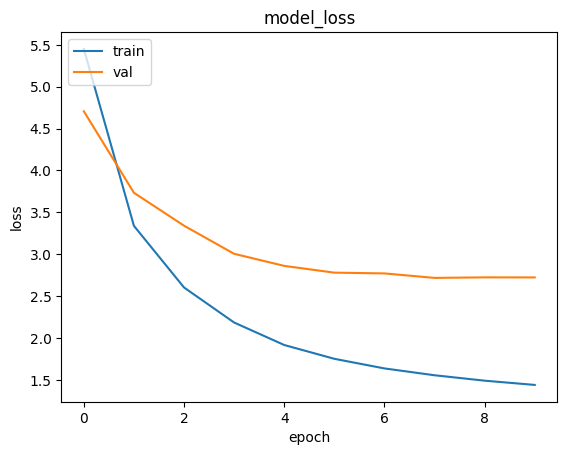

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
transformer.evaluate(val_dataset)

375/375 [==============================] - 53s 46ms/step - loss: 2.7233


2.7233364582061768

# Testing

In [ ]:
# Create a dictionary mapping from index to word for the French vocabulary.
# `index_to_word` will map each index (from 0 to the size of the vocabulary) to its corresponding word.
# The vocabulary is obtained from the `french_vectorize_layer`.
index_to_word = {x: y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                      french_vectorize_layer.get_vocabulary())}


In [ ]:
def translator(english_sentence):
    """
    Translate an English sentence into French using the trained Transformer model.
    
    Args:
        english_sentence (str): The input sentence in English.
    
    Returns:
        str: The translated sentence in French.
    """

    # Tokenize the English sentence using the vectorization layer
    tokenized_english_sentence = english_vectorize_layer([english_sentence])
    
    # Initialize the shifted target sequence with the start token
    shifted_target = 'starttoken'
    
    # Loop to generate each word in the translated French sentence
    for i in range(FRENCH_SEQUENCE_LENGTH):
        # Tokenize the current shifted target sequence
        tokenized_shifted_target = french_vectorize_layer([shifted_target])
        
        # Predict the next word using the Transformer model
        output = transformer.predict([tokenized_english_sentence, tokenized_shifted_target])
        
        # Get the index of the predicted word with the highest probability
        french_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
        
        # Convert the word index to the corresponding French word
        current_word = index_to_word[french_word_index]
        
        # Stop if the end token is predicted
        if (current_word == 'endtoken'):
            break
        
        # Append the predicted word to the shifted target sequence
        shifted_target += ' ' + current_word
    
    # Return the translated sentence, excluding the 'starttoken'
    return shifted_target[11:]


In [ ]:
translator('Have you ever watched soccer under the rain?')

1/1 [==============================] - 0s 45ms/step


'astu déjà regardé au foot sous la pluie'

In [ ]:
translator("what is your name?")

1/1 [==============================] - 0s 49ms/step


'quel est ton nom de ton nom'

In [ ]:
translator('My hotel told me to call you. ')

1/1 [==============================] - 0s 28ms/step


'mon hôtel ma dit de vous appeler'

In [ ]:
translator('She handed him the money')

1/1 [==============================] - 0s 28ms/step


'elle lui a donné largent de largent'